In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re 
import gensim
import pickle # Useful for storing big datasets
import nltk
from nltk.stem import *
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Helper functions

In [2]:
# function to group dataset by features when rows can belong to multiple groups
def groupby_many(data, groups):
    """
    Groups a Series or DataFrame object where each row can belong to many groups.

    Parameters
    ----------
    data : Series or DataFrame
        The data to group
    groups : iterable of iterables
        For each row in data, the groups that row belongs to.
        A row can belong to zero, one, or multiple groups.

    Returns
    -------
    A GroupBy object    
    """ 
    pairs = [(i, g) for (i, gg) in enumerate(groups) for g in gg]
    row, group = zip(*pairs)
    return data.iloc[list(row)].groupby(list(group))


def draw_plot1(year):
    df=movies
    df=df[df['year']==year]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top genres of each year')


def draw_plot2(genre):
    df=movies
    df=df[df['genres'].apply(lambda x: genre in x)]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['countries'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top countries for each genre')


### Loading the data and naming the columns 

In [3]:
path = 'MovieSummaries/'

character=pd.read_csv(path+'character.metadata.tsv',sep='\t',header=None, names=['wiki_movie_ID','Freebase_movie_ID','release_date','character_name','actor_birth','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])
cmu_movies = pd.read_csv(path+'movie.metadata.tsv',sep='\t',header=None,names=['wiki_movie_ID','Freebase_movie_ID','movie_name','date','revenue','runtime','languages','countries','genres'])
plot_summary = pd.read_csv(path+'plot_summaries.txt',sep='\t',header=None,names=['wiki_movie_ID','summary'])
imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
ratings = pd.read_csv(path+'rating.tsv',sep='\t')
complementary_data = pd.read_csv(path+'complementary_data.csv')
top_actor = pd.read_csv(path+'top_actor.csv') ## from imdb




<ipython-input-3-cc33b73b8bc8>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
<ipython-input-3-cc33b73b8bc8>:8: DtypeWarning: Columns (0,1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  complementary_data = pd.read_csv(path+'complementary_data.csv')


In [4]:
display('CHARACTERS:', character.head())
display('CMU MOVIES:',cmu_movies.head())
display('PLOT SUMMARIES:',plot_summary.head())
display('IMDB MOVIES:',imdb_movies.head())
display('RATINGS:',ratings.head())
display('COMPLEMENTARY:',complementary_data.head())
display('TOP ACTORS:',top_actor.head())

'CHARACTERS:'

,wiki_movie_ID,Freebase_movie_ID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


'CMU MOVIES:'

,wiki_movie_ID,Freebase_movie_ID,movie_name,date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


'PLOT SUMMARIES:'

,wiki_movie_ID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


'IMDB MOVIES:'

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


'RATINGS:'

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


'COMPLEMENTARY:'

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,69.0,suomi,Released,NaN,Ariel,7.1,40.0,2.0,1.0,2.0
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,76.0,English,Released,NaN,Shadows in Paradise,7.0,32.0,1.0,1.0,3.0
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,...,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485.0,2.0,1.0,1.0
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,...,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69.0,3.0,2.0,1.0
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,...,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4.0,1.0,1.0,5.0


'TOP ACTORS:'

,Position,Const,Created,Modified,Description,Name,Known For,Birth Date
0,1,nm0000134,2014-03-09,2014-03-09,NaN,Robert De Niro,Raging Bull,1943-08-17
1,2,nm0000197,2014-03-09,2015-10-25,NaN,Jack Nicholson,Chinatown,1937-04-22
2,3,nm0000008,2014-03-09,2014-03-09,NaN,Marlon Brando,Apocalypse Now,1924-04-03
3,4,nm0000243,2014-03-09,2014-03-09,NaN,Denzel Washington,Fences,1954-12-28
4,5,nm0000031,2014-03-09,2014-03-09,NaN,Katharine Hepburn,The Lion in Winter,1907-05-12


In [5]:
#   UNIQUE MOVIE NAMES
print('Number of different movie names in CMU dataset : ',len(cmu_movies.movie_name.unique()))
print('Number of different movie names in IMDb dataset : ',len(imdb_movies.originalTitle.unique()))

Number of different movie names in CMU dataset :  75478
Number of different movie names in IMDb dataset :  4305335


In [6]:
# Create 2 features for the month and the year of releasing of the movies
cmu_movies['month_day'] = cmu_movies['date'].apply(lambda x: x[5:] if len(str(x))>3 else np.nan)
cmu_movies['year'] = cmu_movies['date'].apply(lambda x: x[0:4] if len(str(x))>3 else x)
cmu_movies=cmu_movies.drop('date', axis = 1)

### Merging CMU and IMDB datasets

In [7]:
merged_movies = cmu_movies.merge(imdb_movies,left_on=['movie_name', 'year'],right_on=['primaryTitle', 'startYear'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)


Size of the new dataset :  (61081, 19)


In [8]:
#adding the ratings feature
movies_with_ratings= merged_movies.merge(ratings, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)

Size of the dataset with the ratings :  (50834, 21)


In [9]:
movies_with_ratings.head()

,wiki_movie_ID,Freebase_movie_ID,movie_name,revenue,runtime,languages,countries,genres_x,month_day,year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,55237
1,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.9,19
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",,1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.7,40
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",,1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,6.0,590
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",05-29,1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16


### Pre-process the data : cleaning, engineering and standardizing

In [10]:
#Dropping useless or redundant features
movies_with_ratings = movies_with_ratings.drop('genres_y', axis = 1)
movies_with_ratings = movies_with_ratings.rename(columns = {'genres_x':'genres'})
movies_with_ratings = movies_with_ratings.drop('Freebase_movie_ID', axis = 1)
movies_with_ratings = movies_with_ratings.drop('primaryTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('originalTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('runtimeMinutes', axis = 1)
movies_with_ratings = movies_with_ratings.drop('startYear', axis = 1)

movies_with_ratings['year']=movies_with_ratings['year'].astype(int)

In [11]:
#Remove the 'key' part of languages, countries and genres features
movies_with_ratings['languages'] = movies_with_ratings['languages'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['countries'] = movies_with_ratings['countries'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['genres'] = movies_with_ratings['genres'].apply(lambda x: list(json.loads(x).values()))

In [12]:
print('The percentage of null values for the feature endYear is', np.array(movies_with_ratings.endYear == '\\N').sum()/movies_with_ratings.shape[0])

The percentage of null values for the feature endYear is 0.993390250619664


The percentage of rows containing the feature endYear is very low, so we remove this feature.

In [13]:
movies_with_ratings = movies_with_ratings.drop('endYear', axis = 1)

In [14]:
#removing movies with no votes
movies_with_ratings = movies_with_ratings[movies_with_ratings['numVotes']>0]

In [15]:
movies_with_ratings.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237
1,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0594845,tvEpisode,0,7.9,19
2,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40
3,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590
4,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16


In [16]:
#adding the budget feature
movies= movies_with_ratings.merge(complementary_data[['imdb_id','budget', 'popularity','production_companies']], left_on='tconst', right_on='imdb_id', how='inner')
print('Size of the dataset with the ratings : ', movies.shape)

Size of the dataset with the ratings :  (42636, 18)


In [17]:
#adding profit column
movies['budget'] = movies['budget'].astype(float)
movies['revenue'] = movies['revenue'].astype(float)
movies['profit'] = movies['revenue'] - movies['budget']
movies.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,Screen Gems,-13989168.0
1,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40,tt0094806,0.0,1.80E-05,none,NaN
2,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590,tt0083949,0.0,0.123849,Dieter Geissler Filmproduktion,NaN
3,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16,tt0002894,0.0,0.000347,Keystone Film Company,NaN
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,1600000.0


In [18]:
movies=movies[movies.revenue>0]
movies=movies[movies.budget!=0]
display(movies)

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,Screen Gems,-13989168.0
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,1600000.0
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",11-08,1989,tt0097499,movie,0,7.5,30168,tt0097499,9000000.0,1.161514,BBC Films,1161099.0
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",08-27,1964,tt0058331,movie,0,7.8,173216,tt0058331,6000000.0,4.882687,Walt Disney Productions,96272727.0
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",06-27,2001,tt0255819,movie,0,6.4,14988,tt0255819,16000000.0,1.07838,Columbia Pictures,13381649.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42575,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Thriller, Disaster, Action, Action/Adventure]",01-10,1997,tt0120390,movie,0,4.9,11923,tt0120390,55000000.0,1.640388,Metro-Goldwyn-Mayer (MGM),-43461765.0
42593,303933,Twister,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",05-10,1996,tt0117998,movie,0,6.4,197492,tt0117998,92000000.0,3.535778,Universal Pictures,402471524.0
42594,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",03-11,2011,tt0945513,movie,0,7.5,520621,tt0945513,32000000.0,4.41211,The Mark Gordon Company,115332697.0
42612,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",06-29,1988,tt0094898,movie,0,7.1,208557,tt0094898,39000000.0,2.50055,Paramount Pictures,249752301.0


In [19]:
movies["weighted_rating"]=movies.numVotes.apply(np.log10)*movies.averageRating


In [20]:
##or instead if we choose popularity
#movies["weighted_rating"]=movies.popularity*movies.averageRating


In [21]:
COLUMNS = ['profit', 'weighted_rating']

for i in range(len(COLUMNS)):
     movies[COLUMNS] = (movies[COLUMNS] - movies[COLUMNS].mean())/(movies[COLUMNS].std())



#### Sucess Metric

In [22]:
movies["success"]= (movies.weighted_rating+movies.profit)/2

In [23]:
movies.success.describe()

count    3.681000e+03
mean    -9.651491e-18
std      8.418216e-01
min     -1.827881e+00
25%     -5.288955e-01
50%     -1.266296e-01
75%      3.721302e-01
max      1.088298e+01
Name: success, dtype: float64

#### We will now check for non unicity of the movies in the dataset:

In [24]:
duplicates = movies.loc[movies.duplicated(subset=['wiki_movie_ID'], keep = False)]

In [25]:
duplicates.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success
7839,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0407304,...,0,6.5,449303,tt0407304,132000000.0,5.685105,Paramount Pictures,3.183340,0.760032,1.971686
7840,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0449040,...,0,3.2,2656,tt0449040,1000000.0,0.571862,Asylum,4.216298,-2.530605,0.842847
36167,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0804443,...,0,4.0,3783,tt0804443,22000000.0,0.357426,Hyde Park Films,-0.068944,-2.102580,-1.085762
36168,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0856162,...,0,6.3,83,tt0856162,4000.0,0.000576,none,0.104498,-2.386051,-1.140776


We will consider as duplicates the movies having same title and titleType. Our strategy is to drop duplicates, keeping the movie with the highest 'popularity', i.e. highest vote count

In [26]:
for i in range(len(duplicates.wiki_movie_ID.unique())):# for loop per each duplicate
    orig = movies[movies.wiki_movie_ID == duplicates.wiki_movie_ID.unique()[i]] # find them in the original dataset
    movies = movies.drop(list(orig[orig.numVotes !=orig.numVotes.max()].index)) # drop rows that don't have the maximum number of votes


In [27]:
#keep only principal genres 

principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']

def common_data(list1, list2):
    a_set = set(list1)
    b_set = set(list2)
    intersec = a_set.intersection(b_set)
    if len(intersec) > 0:
        return list(intersec)
    else : 
        return 0
        


movies['genres']= movies['genres'].apply(lambda x: common_data(x,principal_genres))
movies = movies[movies['genres']!=0]
display(movies)


,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Thriller, Action, Horror]",08-24,2001,tt0228333,...,0,4.9,55237,tt0228333,28000000.0,1.124671,Screen Gems,-0.552144,-0.963467,-0.757805
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],[Comedy],08-16,1938,tt0029852,...,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,-0.429220,-0.992895,-0.711058
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],[Drama],11-08,1989,tt0097499,...,0,7.5,30168,tt0097499,9000000.0,1.161514,BBC Films,-0.432681,0.358668,-0.037006
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Comedy, Fantasy, Drama]",08-27,1964,tt0058331,...,0,7.8,173216,tt0058331,6000000.0,4.882687,Walt Disney Productions,0.317291,1.285773,0.801532
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],[Drama],06-27,2001,tt0255819,...,0,6.4,14988,tt0255819,16000000.0,1.07838,Columbia Pictures,-0.336320,-0.518339,-0.427329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,10149834,Ponyo,202614288.0,101.0,[Japanese Language],[Japan],"[Fantasy, Drama]",07-19,2008,tt0876563,...,0,7.6,144403,tt0876563,41677699.0,4.196854,Studio Ghibli,0.827177,1.075424,0.951301
42575,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Action, Thriller]",01-10,1997,tt0120390,...,0,4.9,11923,tt0120390,55000000.0,1.640388,Metro-Goldwyn-Mayer (MGM),-0.784540,-1.379856,-1.082198
42594,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Science Fiction, Action, Thriller, Drama]",03-11,2011,tt0945513,...,0,7.5,520621,tt0945513,32000000.0,4.41211,The Mark Gordon Company,0.467583,1.542670,1.005126
42612,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Comedy, Romance Film, Drama]",06-29,1988,tt0094898,...,0,7.1,208557,tt0094898,39000000.0,2.50055,Paramount Pictures,1.527505,0.890844,1.209175


### Visualization of the data

In [28]:
#plot of the top 20 languages 
languages_20 = groupby_many(movies, movies['languages'])[['success']].mean().sort_values('success', ascending=False)[0:20]
display(languages_20)

,success
Old English language,3.505717
Amharic Language,2.574135
Assyrian language,2.574135
Sicilian Language,2.527750
Nepali Language,2.487876
Pawnee Language,2.169453
Zulu Language,2.004234
Xhosa Language,2.004234
Croatian language,1.832413
Hmong language,1.792573


#### Distributions

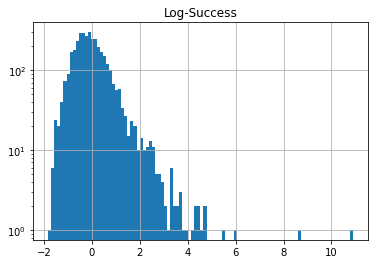

In [29]:
fig, axes = plt.subplots(1, 1)

movies.success.hist(bins=100, log=True)
axes.set_title('Log-Success')
plt.show()

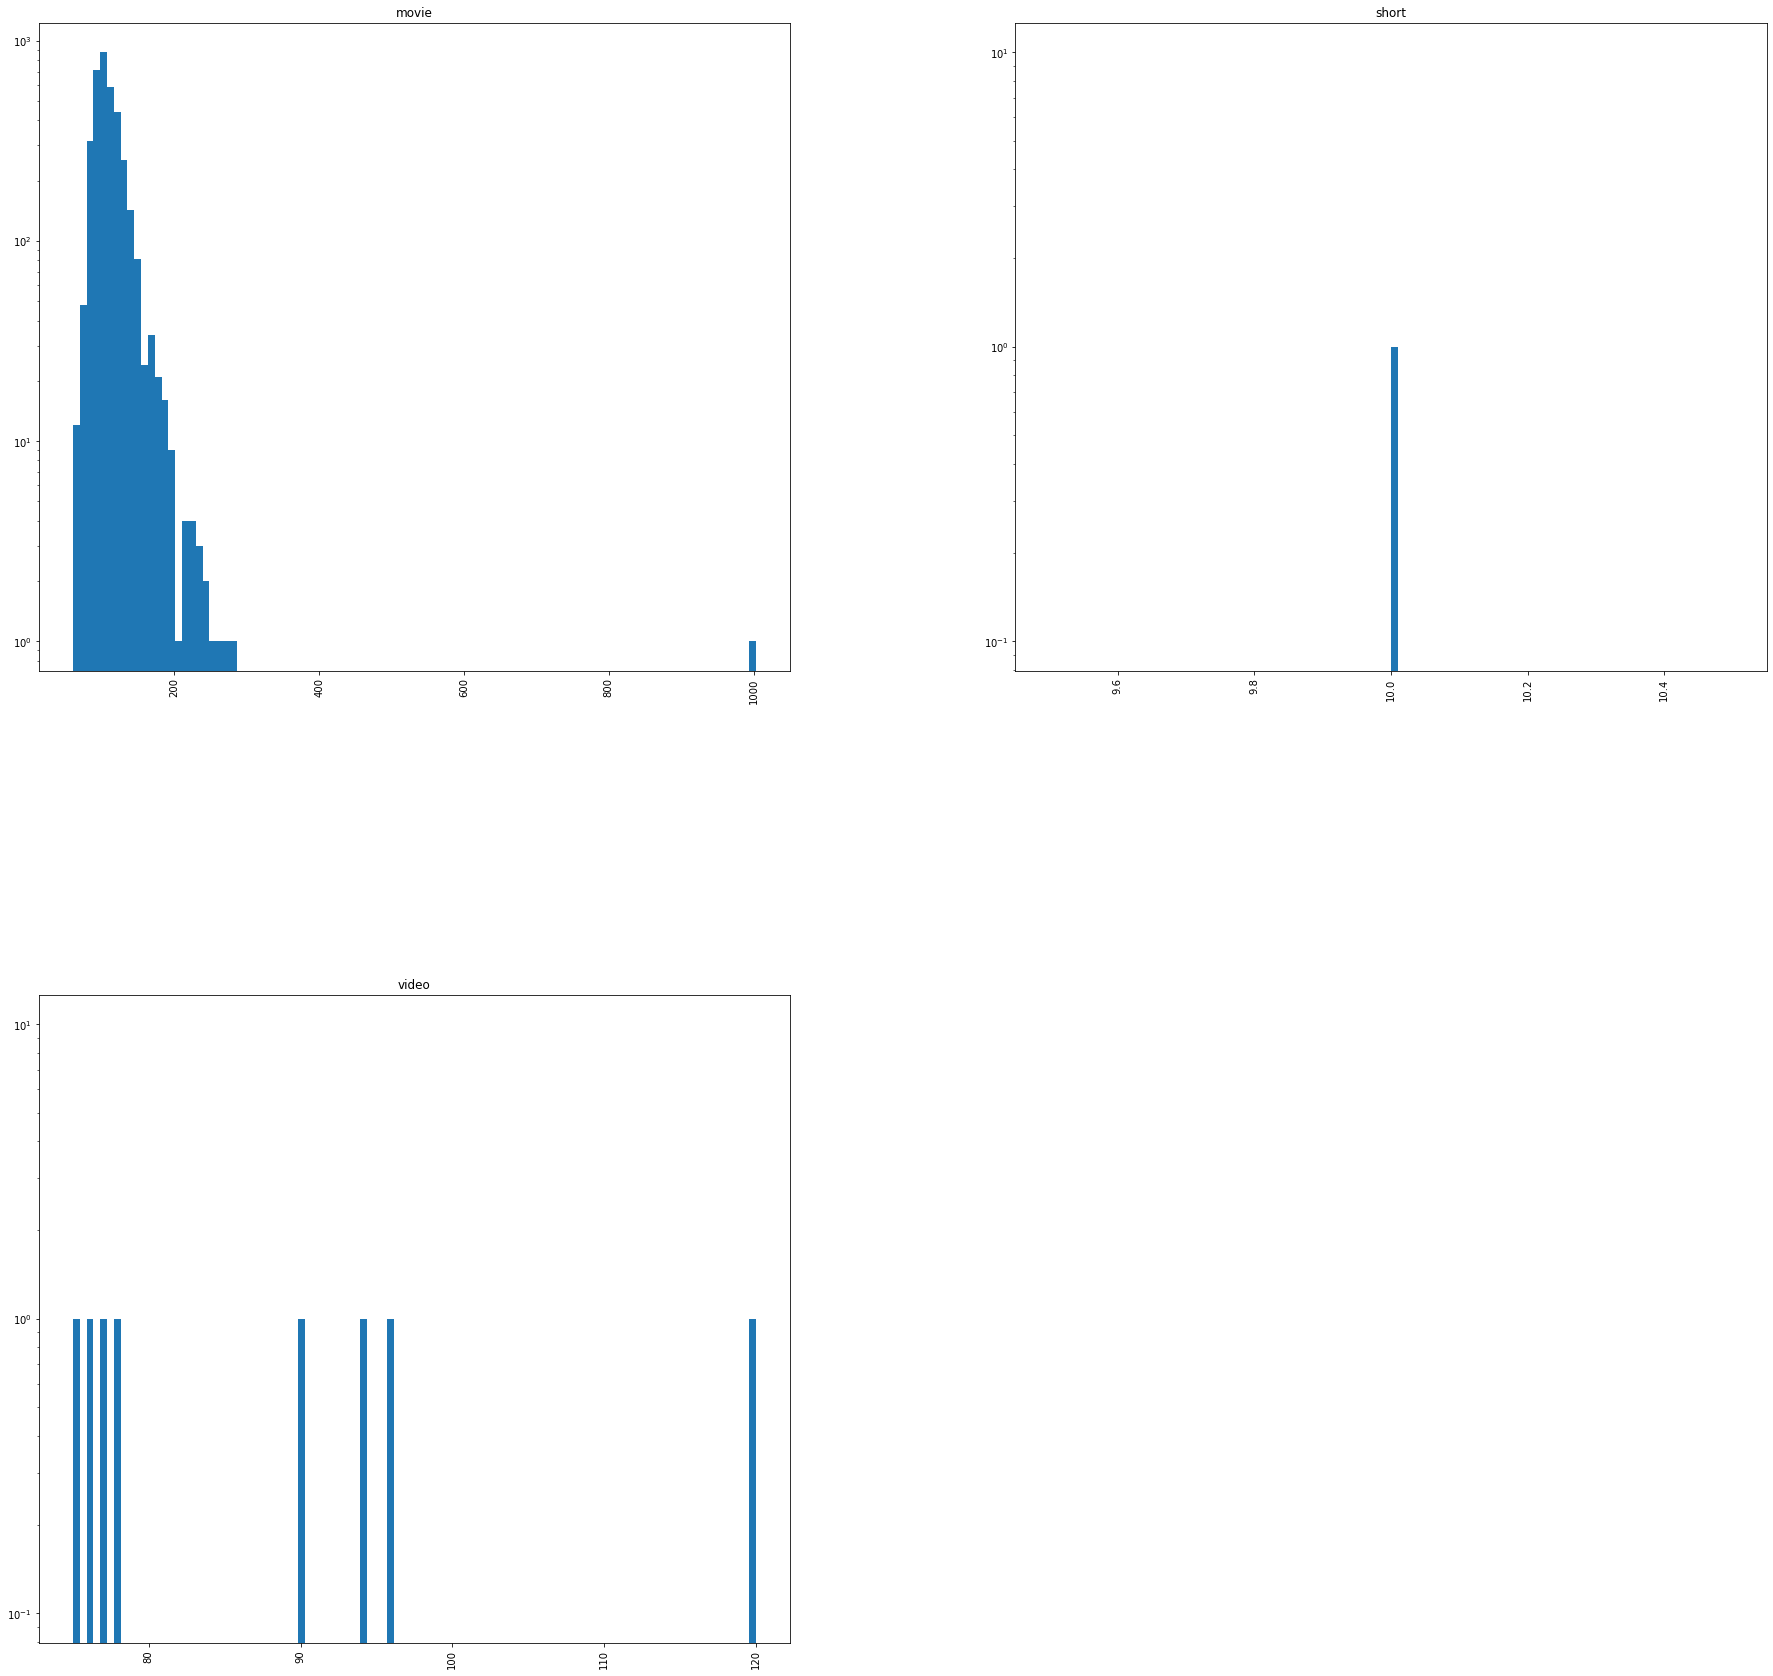

In [30]:
movies['runtime'].hist(bins=100,by=movies['titleType'],log=True,figsize=(30,30))
plt.title('Runtime')
plt.show()

#### Top languages, countries, and genres

Text(0.5, 1.0, 'Mean Success against the most encountered languages in movies')

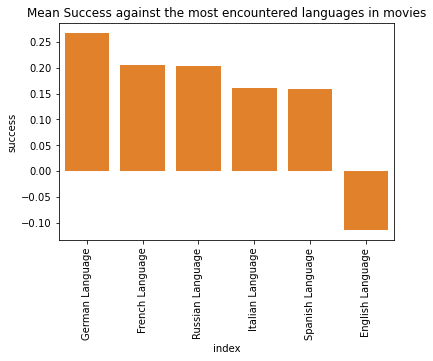

In [31]:
fig, axs = plt.subplots(1)
df1=groupby_many(movies, movies['languages'])[['success']].median()
df2=groupby_many(movies, movies['languages'])['success'].count().to_frame('count')
df2=df2[df2['count']>100]
df2=df2.reset_index()
df1=df1.reset_index()


lang=df1.merge(df2,on='index')
lang=lang.sort_values('success',ascending=False)
g=sns.barplot(data=lang,x='index',y='success',color='tab:orange')
plt.xticks(rotation=90)

plt.title('Mean Success against the most encountered languages in movies')


In the most common languages we can encounter in movies, German language is the most successful 

Text(0.5, 1.0, 'Mean Success against the most encountered countries in movies')

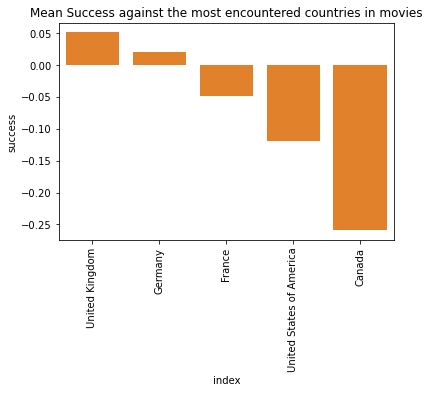

In [32]:


fig, axs = plt.subplots(1)
df1=groupby_many(movies, movies['countries'])[['success']].median()
df2=groupby_many(movies, movies['countries'])['success'].count().to_frame('count')
df2=df2[df2['count']>100]
df2=df2.reset_index()
df1=df1.reset_index()


countries=df1.merge(df2,on='index')
countries=countries.sort_values('success',ascending=False)
g=sns.barplot(data=countries,x='index',y='success',color='tab:orange')
plt.xticks(rotation=90)

plt.title('Mean Success against the most encountered countries in movies')

#display(df1['index'])

Text(0.5, 1.0, 'Mean success for each genre')

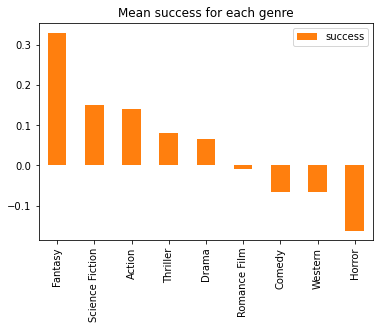

In [33]:
fig, axs = plt.subplots(1)
groupby_many(movies, movies['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('Mean success for each genre')




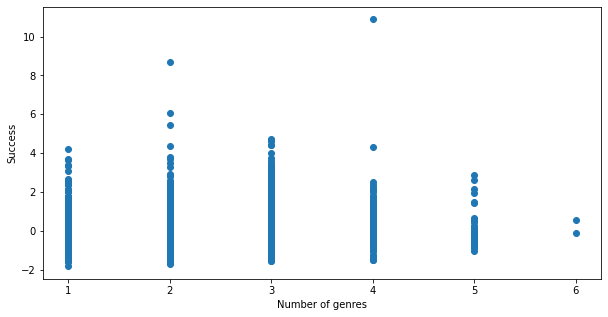

In [34]:
# add a column with the number of genres
movies['num_genres'] = movies['genres'].apply(lambda x: len(x))
# plot the number of genres vs the success
plt.figure(figsize=(10,5))
plt.scatter(movies['num_genres'], movies['success'])
plt.xlabel('Number of genres')
plt.ylabel('Success')
plt.show()

#### Each year's best genre

In [35]:

slider=widgets.IntSlider(min=movies['year'].min(),max=movies['year'].max(),description='year')

interact(draw_plot1,year=slider)
#display(slider,out)

interactive(children=(IntSlider(value=1915, description='year', max=2012, min=1915), Output()), _dom_classes=(…

<function __main__.draw_plot1(year)>

#### The best countries for each genre

In [36]:
pairs = [(i, g) for (i, gg) in enumerate(movies['genres']) for g in gg]
row, group = zip(*pairs)
group=np.unique(group)
dd= widgets.Dropdown(options=group,value=group[0],description='Select a genre')

interact(draw_plot2,genre=dd)
#display(slider,out)

/opt/anaconda3/lib/python3.8/site-packages/traitlets/traitlets.py:586: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Select a genre', options=('Action', 'Comedy', 'Drama', 'Fantasy', …

<function __main__.draw_plot2(genre)>

In [37]:
# find 'Bahamas' in the countries column
print(movies[movies['countries'].apply(lambda x: 'Bahamas' in x)].index)
list(movies[movies.index == 1750]['countries'])

Int64Index([20637], dtype='int64')


[]

In [38]:
# add a column which contains the number of countries
movies['num_countries'] = movies['countries'].apply(lambda x: len(x))

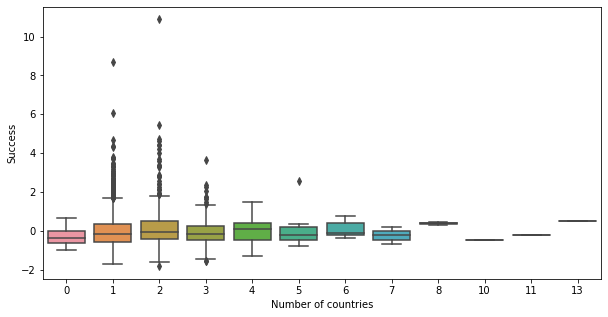

In [39]:
# plot the number of countries vs the success
plt.figure(figsize=(10,5))
sns.boxplot(data=movies,x=movies['num_countries'],y= movies['success'])
plt.xlabel('Number of countries')
plt.ylabel('Success')
plt.show()

In [40]:
# add a column which contains the number of countries
movies['num_languages'] = movies['languages'].apply(lambda x: len(x))

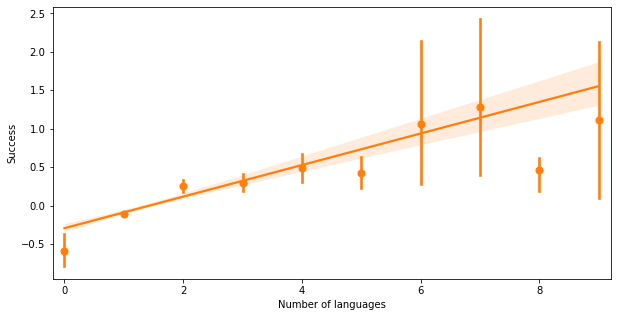

In [41]:
# plot the number of countries vs the success
plt.figure(figsize=(10,5))
sns.regplot(x='num_languages', y='success', data=movies,x_estimator=np.mean,x_ci="ci",color='tab:orange',truncate=True)
plt.xlabel('Number of languages')
plt.ylabel('Success')
plt.xlim((-0.2,9.2))
plt.show()

Correlation between runtime and success (for normal timed movies: 50-200 minutes)

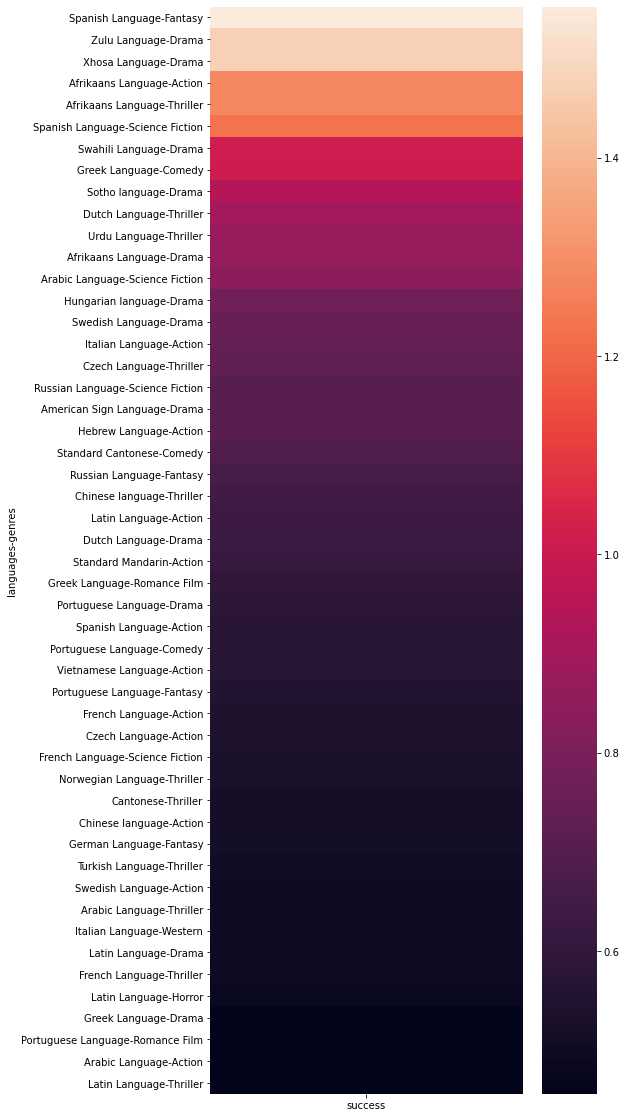

<AxesSubplot:ylabel='languages-genres'>

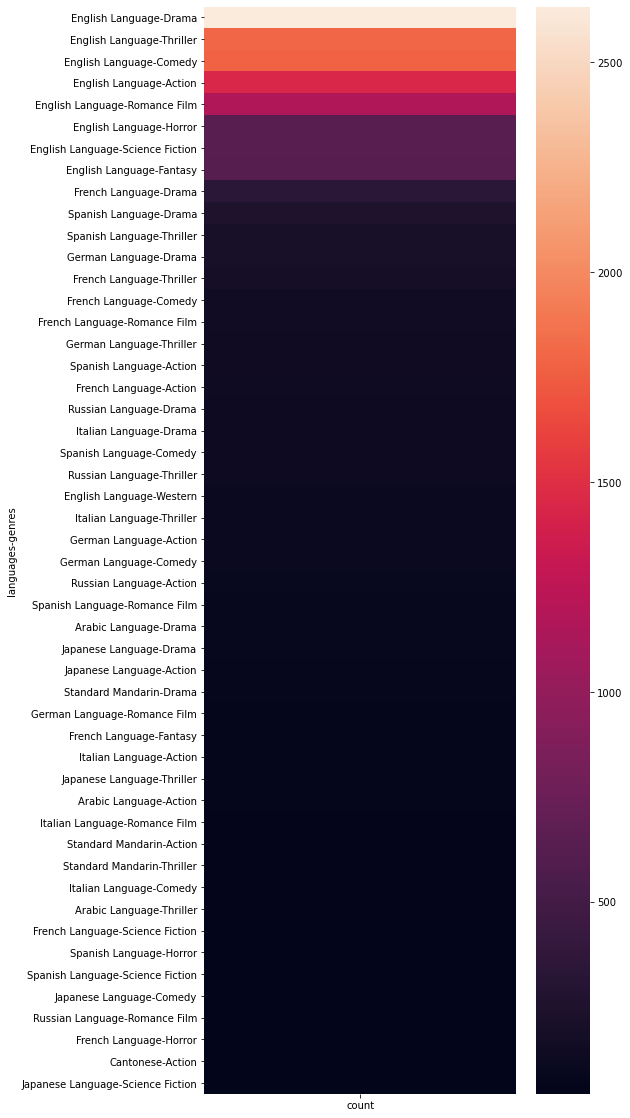

In [67]:
df= movies[['success','languages','countries','genres','wiki_movie_ID']]
df=df.explode('languages')
df=df.explode('countries')
df=df.explode('genres')

df2=df.groupby(['languages','genres'])['success'].count().to_frame('count')
df2=df2[df2['count']>5]
df=df.groupby(['languages','genres'])['success'].mean().to_frame('success')
data=df.merge(df2,on=['languages','genres'])
data=data.drop('count',axis=1)
data=data.sort_values('success',ascending=False)[0:50]
#data=data['success']

plt.figure(figsize=(7,20))
sns.heatmap(data)
plt.show()

plt.figure(figsize=(7,20))
df2=df2.sort_values('count',ascending=False)[0:50]
sns.heatmap(df2)

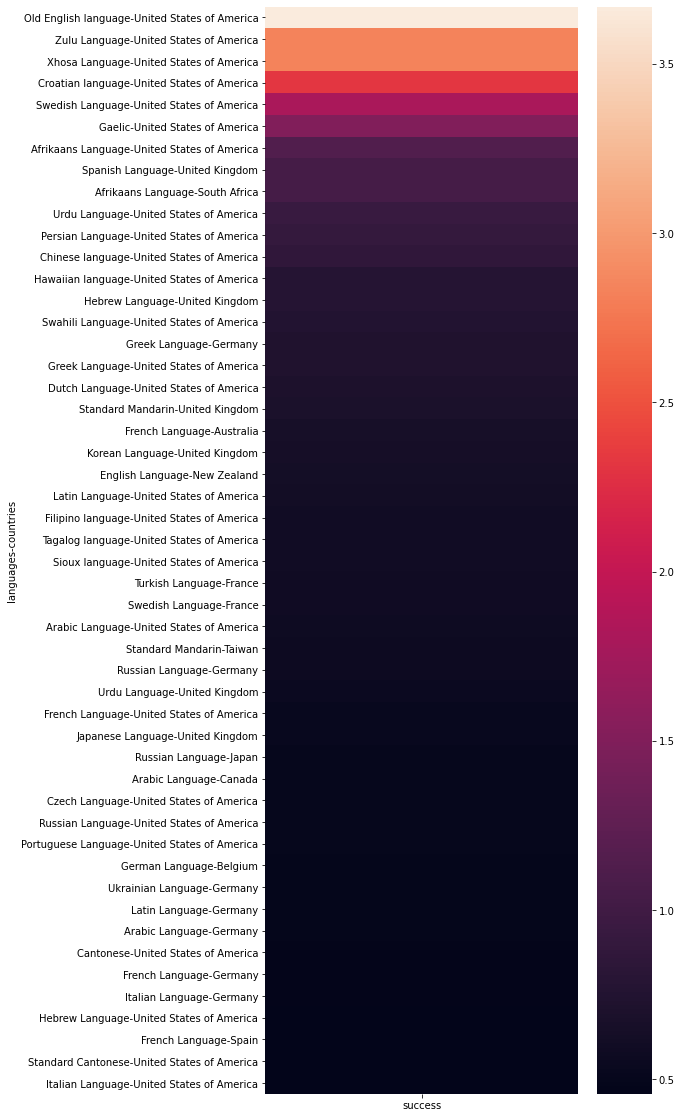

<AxesSubplot:ylabel='languages-countries'>

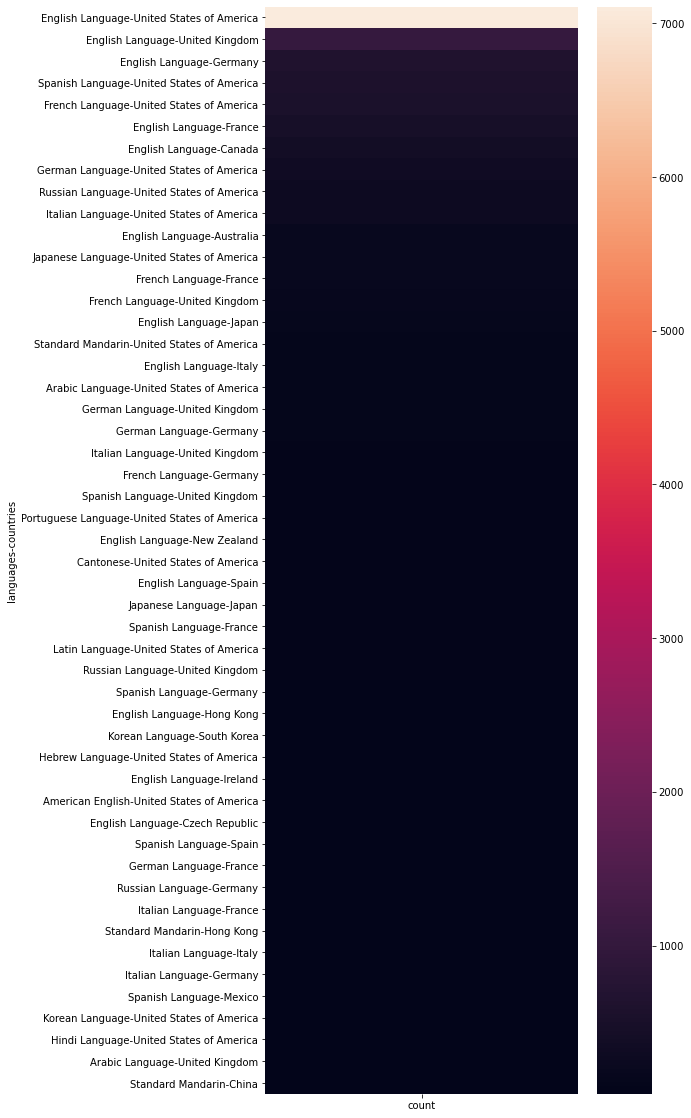

In [68]:
df= movies[['success','languages','countries','genres','wiki_movie_ID']]
df=df.explode('languages')
df=df.explode('countries')
df=df.explode('genres')

df2=df.groupby(['languages','countries'])['success'].count().to_frame('count')
df2=df2[df2['count']>5]
df=df.groupby(['languages','countries'])['success'].mean().to_frame('success')
data=df.merge(df2,on=['languages','countries'])
data=data.drop('count',axis=1)
data=data.sort_values('success',ascending=False)[0:50]
#data=data['success']

plt.figure(figsize=(7,20))
sns.heatmap(data)
plt.show()

plt.figure(figsize=(7,20))
df2=df2.sort_values('count',ascending=False)[0:50]
sns.heatmap(df2)

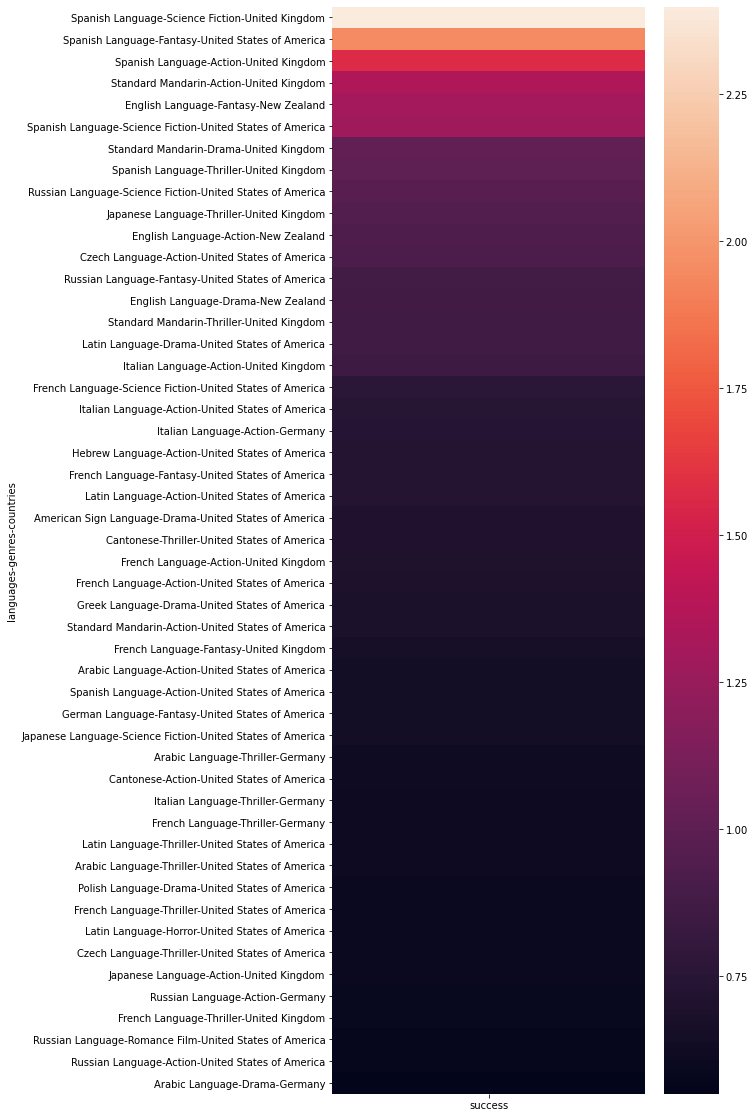

<AxesSubplot:ylabel='languages-genres-countries'>

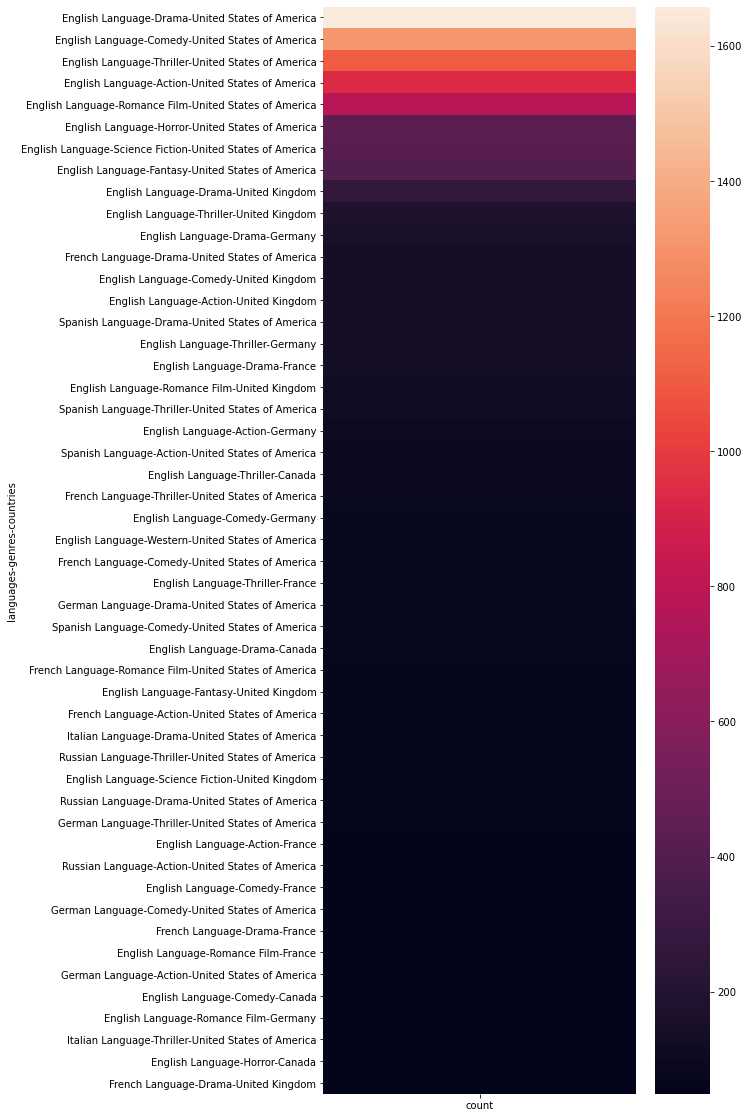

In [69]:
df= movies[['success','languages','countries','genres','wiki_movie_ID']]
df=df.explode('languages')
df=df.explode('countries')
df=df.explode('genres')

df2=df.groupby(['languages','genres','countries'])['success'].count().to_frame('count')
df2=df2[df2['count']>5]
df=df.groupby(['languages','genres','countries'])['success'].mean().to_frame('success')
data=df.merge(df2,on=['languages','genres','countries'])
data=data.drop('count',axis=1)
data=data.sort_values('success',ascending=False)[0:50]
#data=data['success']

plt.figure(figsize=(7,20))
sns.heatmap(data)
plt.show()

plt.figure(figsize=(7,20))
df2=df2.sort_values('count',ascending=False)[0:50]
sns.heatmap(df2)

In [42]:
normal_time_movies= movies[((movies.runtime>=50) & (movies.runtime<=200))]
normal_time_movies.shape

(3582, 24)

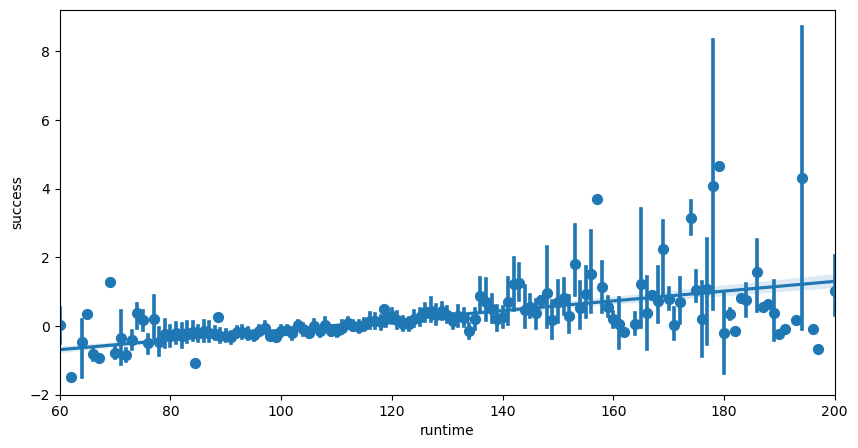

In [77]:
plt.figure(figsize=(10,5))


sns.regplot(x='runtime', y='success', data=normal_time_movies[['success', 'runtime']],x_estimator=np.mean,x_ci="ci",truncate=True)
plt.show()

In [44]:
#Linear dependence
normal_time_movies[['success', 'runtime']].corr()

,success,runtime
success,1.00000,0.33463
runtime,0.33463,1.00000


In [45]:
#Strength of association (spearman's correlation)
normal_time_movies.success.corr(normal_time_movies.runtime, method='spearman')

0.3181690483243509

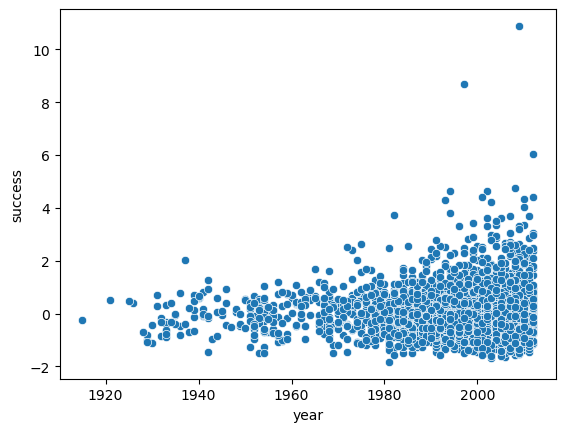

In [81]:
sns.scatterplot(x='year', y='success', data=normal_time_movies[['success', 'year']])
plt.show()


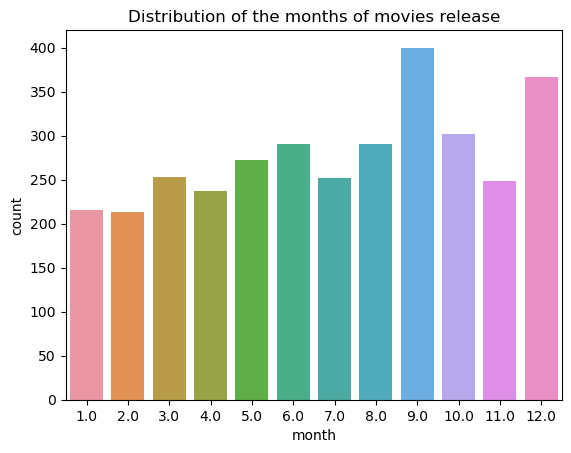

<AxesSubplot:xlabel='month', ylabel='success'>

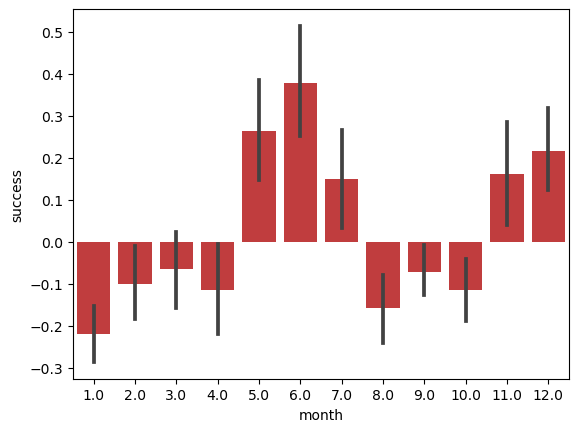

In [83]:
from datetime import datetime
movies['month'] = movies['month_day'].apply(lambda x :(int(x[1]) if x[0]=='0' else int(x[0:2])) if len(x)>0 else None)
df=movies.groupby(movies['month'])['success'].mean()


sns.countplot(data=movies,x='month')
plt.title('Distribution of the months of movies release')
plt.show()

sns.barplot(data=movies,x=movies['month'],y=movies['success'],color='tab:red')

#### Discussion 
We can see that the better month for success correspond to holidays, 1 month in advance. As a movie stays around 1 month in cinema, it explain this. Let's create a parameter 'is_holidays' to analyze if a release during holidays has effect on success !

In [48]:
holidays =[6,7,11,12]
movies['is_holidays']= movies['month'].isin(holidays)
movies['is_holidays']=movies['is_holidays'].apply(lambda x : x if np.isnan(x) else int(x))

In [49]:
movies_and_actors= movies.merge(character,on='wiki_movie_ID',how='inner')

top=50
top_actor=top_actor[top_actor['Position']<top]

movies_and_actors['IsFamousActor']=movies_and_actors['actor_name'].isin(top_actor['Name'])

famous=movies_and_actors.groupby('wiki_movie_ID')['IsFamousActor'].apply(lambda x : any(x)).to_frame('IsFamousActor')

movies=movies.merge(famous,on='wiki_movie_ID',how='left')
movies['IsFamousActor']=movies['IsFamousActor'].apply(lambda x : x if np.isnan(x) else int(x))

<AxesSubplot:xlabel='IsFamousActor', ylabel='success'>

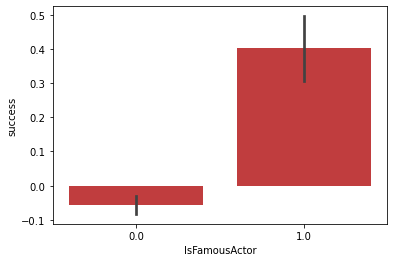

In [50]:
sns.barplot(data=movies,x=movies['IsFamousActor'],y=movies['success'],color='tab:red')

In [51]:
actors = movies_and_actors.groupby('wiki_movie_ID')['actor_name'].count().astype('int').to_frame('number_actors')
movies=movies.merge(actors,on='wiki_movie_ID',how='left')



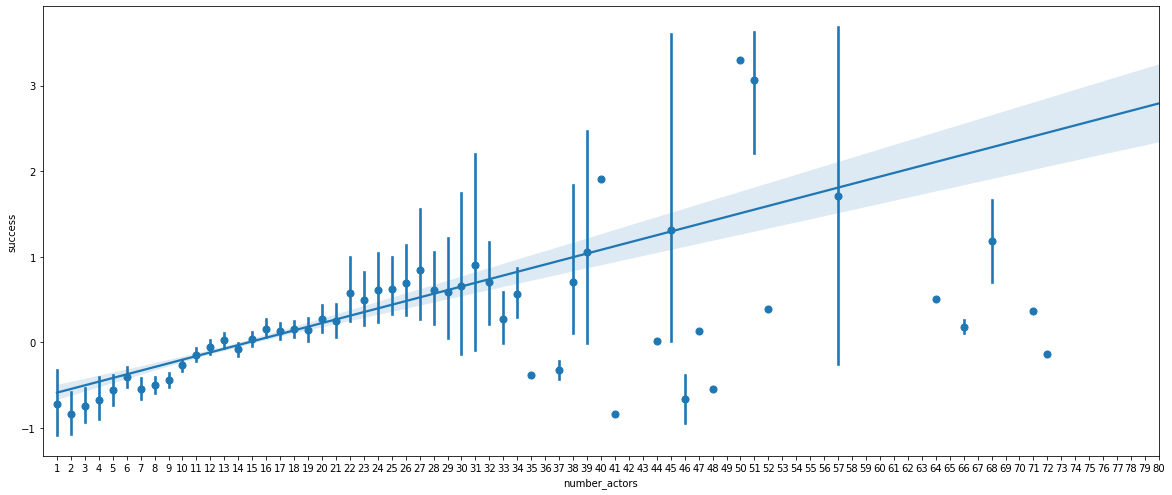

In [52]:
plt.figure(figsize=(20,8.27))
#sns.barplot(data=movies,x=movies['number_actors'],y=movies['success'],color='tab:red')
#plt.show()

#plt.errorbar(x=movies['number_actors'], y=movies['success'], fmt='+')
sns.regplot(x='number_actors', y='success', data=movies,x_estimator=np.mean,x_ci="ci",truncate=True)
plt.xlim(0, 12)
plt.xticks(list(range(1,81)))
plt.show()

sns.reset_defaults()



,actor_age,success
wiki_movie_ID,,
3217,33.250000,0.336823
3333,11.000000,-0.249196
3746,38.384615,0.876352
3837,45.550000,0.804405
3947,NaN,0.429260
...,...,...
35370504,41.500000,0.309760
35581515,61.000000,0.113000
35729649,34.750000,0.547665


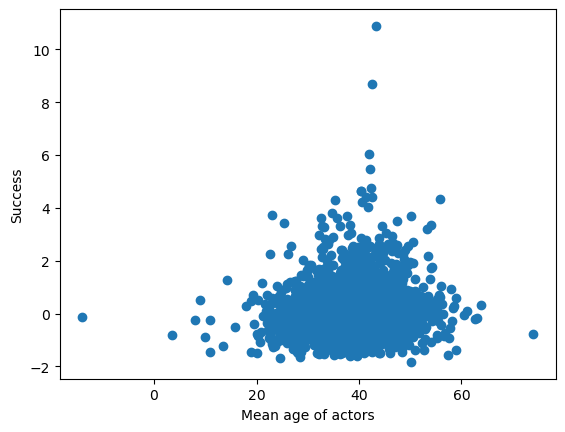

In [53]:
age = movies_and_actors.groupby('wiki_movie_ID')[['actor_age','success']].mean()
display(age)
age=age.dropna()

plt.scatter(age['actor_age'],age['success'])
plt.xlabel('Mean age of actors')
plt.ylabel('Success')
plt.show()


In [54]:
movies=movies.merge(age[['actor_age']],on='wiki_movie_ID',how='left')

In [55]:
movies_and_actors=movies_and_actors.dropna()
movies_and_actors['dominant_gender']=movies_and_actors['actor_gender'].apply(lambda x: 0 if x=='M' else 1)
gender = movies_and_actors.groupby('wiki_movie_ID')['dominant_gender'].mean().apply(lambda x : 'Male' if x<0.5 else 'Female').to_frame('dominant_gender')
movies=movies.merge(gender,on='wiki_movie_ID',how='left')

<AxesSubplot:xlabel='dominant_gender', ylabel='count'>

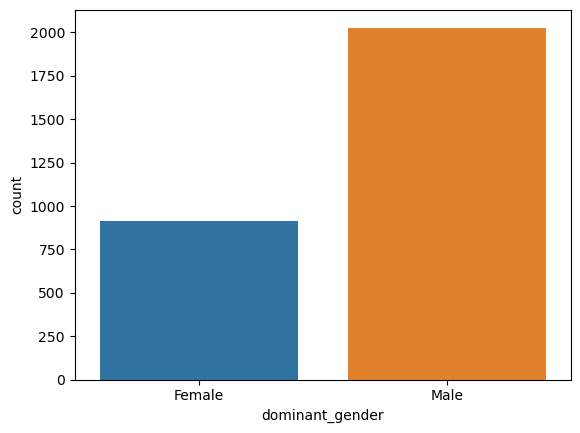

In [56]:
sns.countplot(data=movies,x=movies['dominant_gender'])

<AxesSubplot:xlabel='dominant_gender', ylabel='success'>

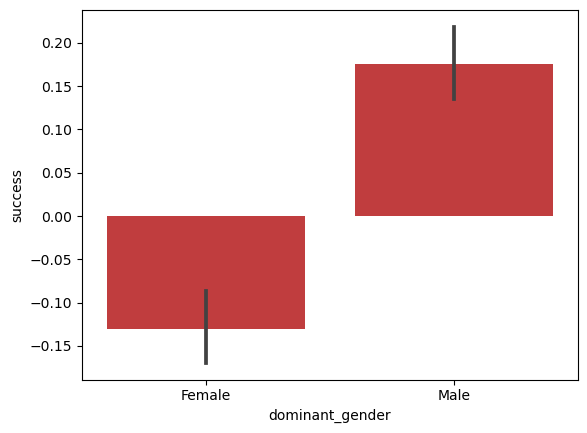

In [57]:
sns.barplot(data=movies,x=movies['dominant_gender'],y=movies['success'],color='tab:red')

In [58]:
movies['dominant_gender']=movies['dominant_gender'].apply(lambda x : 0. if x=='Male' else 1.)

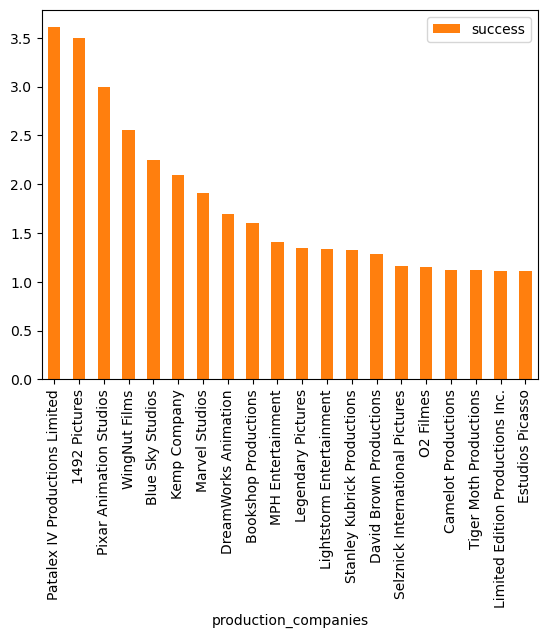

<AxesSubplot:xlabel='IsMajorProducer', ylabel='success'>

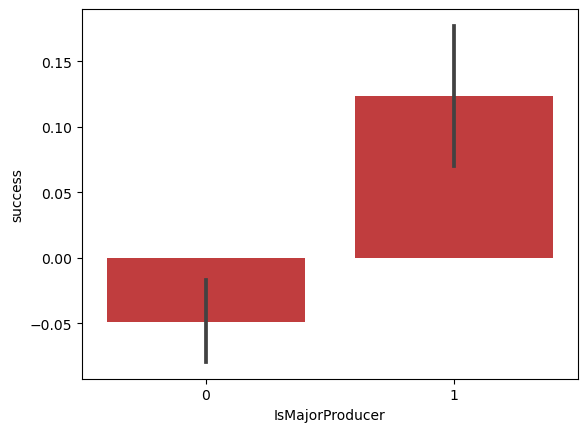

In [59]:
producer = movies.groupby('production_companies')[['success']].mean().sort_values('success',ascending=False)
producer['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
plt.show()

major_producer = ['Universal International Pictures (UI)', 'Universal Pictures','Universal Pictures Corporation', 'Universal Pictures International (UPI)','Paramount Pictures' ,'Paramount Pictures Corporation','Warner Bros.','Warner Bros. Pictures','New Line Cinema','Walt Disney Pictures','Walt Disney Productions','20th Century Fox','Columbia Pictures', 'Columbia Pictures Corporation',
'Columbia Pictures Industries','TriStar Pictures'] ## source : wikipedia
movies['IsMajorProducer']=movies['production_companies'].isin(major_producer)
movies['IsMajorProducer']=movies['IsMajorProducer'].apply(lambda x : x if np.isnan(x) else int(x))

sns.barplot(data=movies,x=movies['IsMajorProducer'],y=movies['success'],color='tab:red')

## Analyze the plot summaries

In [60]:
#!pip install -U gensim==3.8.3
#nltk.download('punkt') # For Stemming
#nltk.download('wordnet') # For Lemmatization
#nltk.download('stopwords') # For Stopword Removal
#nltk.download('omw-1.4')


In [61]:

stopwords = set(nltk.corpus.stopwords.words('english'))

# Remove URL, mentions and hashtags and Proper Nouns
def remove_func(text):
    text = re.sub(r'https?:\S*','',text)
    text = re.sub(r'@\S*','',text)
    text = re.sub(r"\s*[A-Z]\w*\s*", " ", text)
    return re.sub(r'#\S*','',text)

def text_preprocessing(df):
    corpus=[]
    
    lem = WordNetLemmatizer() # For Lemmatization
    stem = PorterStemmer()
    for text in df['summary']:
        words=[w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        words=[stem.stem(w) for w in words]
        corpus.append(words)
    return corpus


In [62]:
principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']



plots = plot_summary.merge(movies,on='wiki_movie_ID') ##.merge(movies[['wiki_movie_ID','averageRating','numVotes','genres']],on='wiki_movie_ID')

min_success = 1
plots_success = plots[plots['success']>=min_success]
plots_by_genre = groupby_many(plots_success, plots_success['genres'])
pd.options.mode.chained_assignment = None
    

Action
 
Topic: 0 
Words: 0.008*"find" + 0.008*"attack" + 0.007*"human" + 0.007*"return" + 0.007*"destroy" + 0.007*"escap" + 0.006*"ship" + 0.006*"forc" + 0.006*"chalic" + 0.005*"alien"
Topic: 1 
Words: 0.014*"dream" + 0.007*"team" + 0.006*"back" + 0.006*"time" + 0.005*"kick" + 0.004*"level" + 0.004*"fight" + 0.004*"father" + 0.004*"child" + 0.004*"enter"
Topic: 2 
Words: 0.014*"kill" + 0.009*"find" + 0.008*"escap" + 0.006*"use" + 0.006*"take" + 0.006*"reveal" + 0.006*"meet" + 0.006*"discov" + 0.006*"polic" + 0.005*"learn"
 
Comedy
 
Topic: 0 
Words: 0.021*"penguin" + 0.013*"anim" + 0.012*"sing" + 0.012*"danc" + 0.010*"fish" + 0.008*"ring" + 0.008*"mate" + 0.006*"egg" + 0.006*"zoo" + 0.006*"heartsong"
Topic: 1 
Words: 0.011*"find" + 0.007*"attempt" + 0.006*"get" + 0.006*"tri" + 0.006*"day" + 0.006*"back" + 0.006*"return" + 0.005*"reveal" + 0.005*"time" + 0.005*"take"
Topic: 2 
Words: 0.010*"love" + 0.007*"wed" + 0.006*"make" + 0.006*"parti" + 0.005*"marri" + 0.005*"friend" + 0.005*"rel

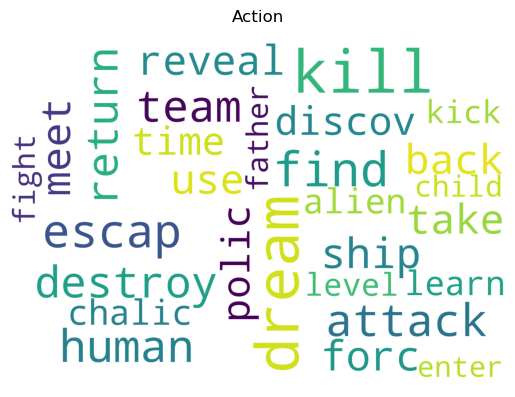

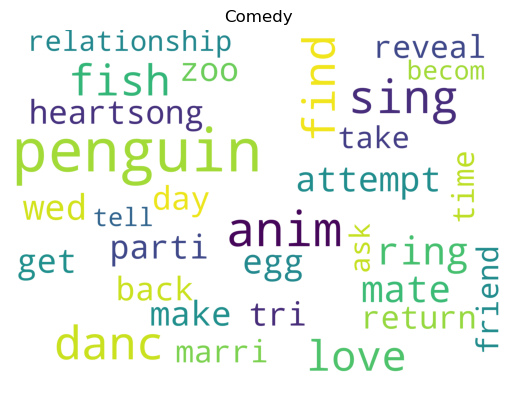

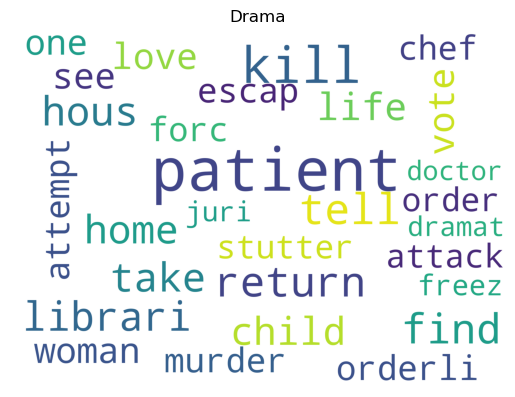

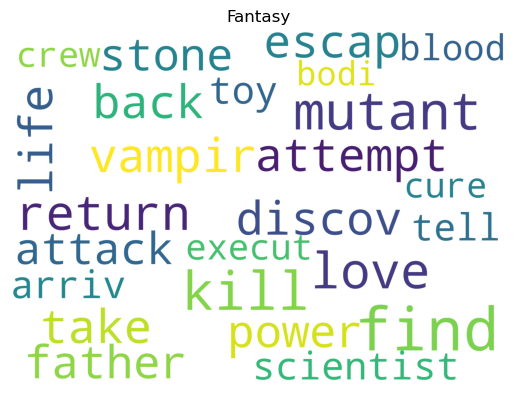

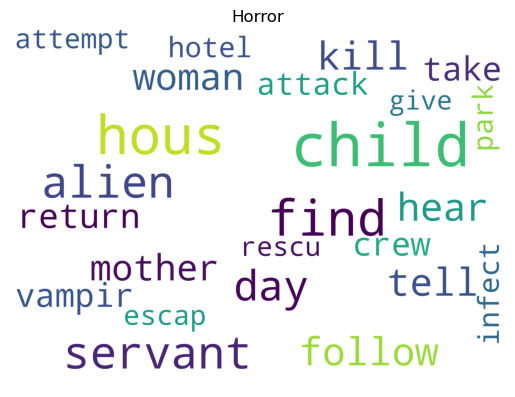

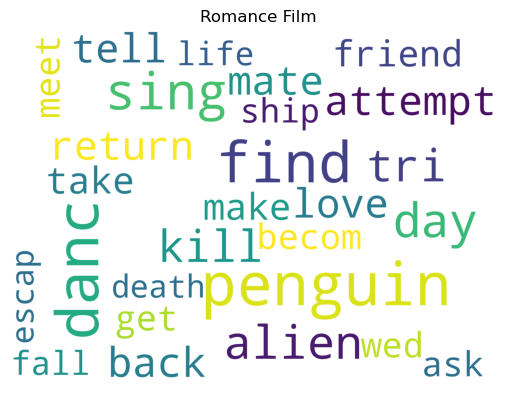

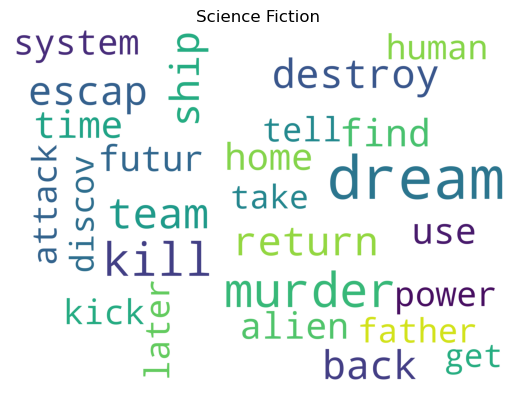

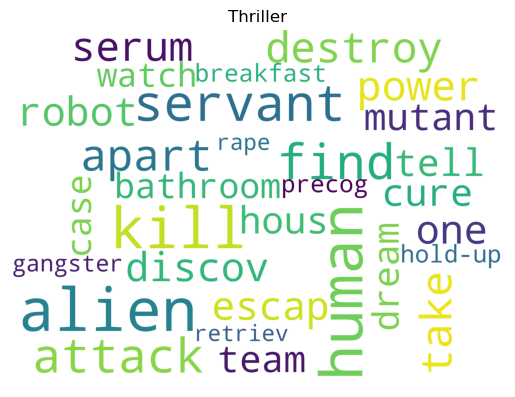

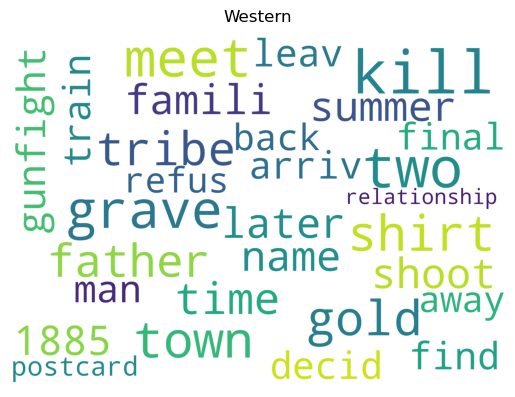

In [63]:
lda_models={}
lda_bow={}
for genre in principal_genres : 

    print(genre)
    print(' ')
    genre_movies = plots_by_genre.get_group(genre)
    genre_movies['summary']=genre_movies['summary'].apply(remove_func)
    corpus = text_preprocessing(genre_movies)
    # Transform to gensim dictionary
    dic = gensim.corpora.Dictionary(corpus) 
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    pickle.dump(bow_corpus, open('corpus_'+genre+'.pkl', 'wb'))
    dic.save('dictionary_'+genre+'.gensim')
    lda_models[genre] = gensim.models.ldamodel.LdaModel(bow_corpus, id2word=dic,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=200,
                                           per_word_topics=True)
    
    # We print words occuring in each of the topics as we iterate through them
    for idx, topic in lda_models[genre].print_topics(num_words=10):    
        print('Topic: {} \nWords: {}'.format(idx, topic))
        
    print(" ")
    topics = lda_models[genre].show_topics(formatted=False)
    topic_words = {}
    for i in range(3):
        topic_words.update(dict(topics[i][1]))
    cloud = WordCloud(background_color='white',width=2500,height=1800)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    fig = plt.figure()
    plt.gca().set_title(genre)
    plt.gca().axis('off')
    plt.imshow(cloud)

#### Discussion 
We can see that in all genres, the word 'kill' arises very frequently. It is like something necessary for the movie to be successful. So, we will analize the influence of the presence of the lexical field of 'kill'.

In [64]:
def is_kill(text):

    lem = WordNetLemmatizer() # For Lemmatization
    stem = PorterStemmer()
    words=[w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
    words=[lem.lemmatize(w) for w in words if len(w)>2]
    words=[stem.stem(w) for w in words]
    count = words.count('kill')
    if count>0 : 
        return 1
    else : 
        return 0

In [65]:
plots['is_kill']=plots['summary'].apply(is_kill)


In [66]:
movies=movies.merge(plots[['wiki_movie_ID','is_kill']],on='wiki_movie_ID',how='left')

<AxesSubplot:xlabel='is_kill', ylabel='success'>

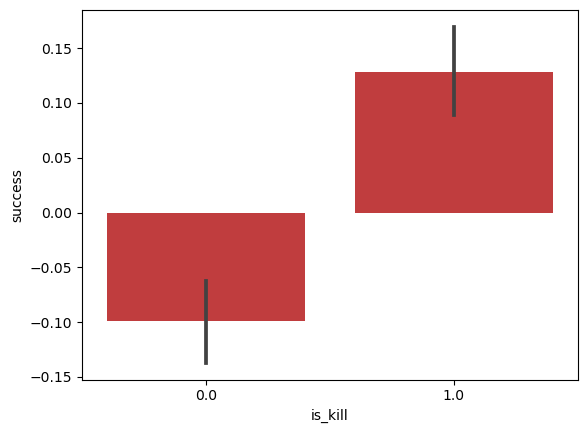

In [67]:
sns.barplot(data=movies,x=movies['is_kill'],y=movies['success'],color='tab:red')

In [68]:
movies_for_reg= movies[['success','year','month','runtime','dominant_gender','is_holidays','IsFamousActor','number_actors','IsMajorProducer','is_kill','num_languages']]


mlb_g = MultiLabelBinarizer()

g=pd.DataFrame(mlb_g.fit_transform(movies['genres']),columns=mlb_g.classes_, index=movies.index)

movies_for_reg=pd.concat([movies_for_reg,g], axis=1)
movies_for_reg=pd.get_dummies(movies_for_reg)
movies_for_reg=movies_for_reg.dropna()
display(movies_for_reg)

,success,year,month,runtime,dominant_gender,is_holidays,IsFamousActor,number_actors,IsMajorProducer,is_kill,num_languages,Action,Comedy,Drama,Fantasy,Horror,Romance Film,Science Fiction,Thriller,Western
0,-0.757805,2001,8.0,98.0,1.0,0,0.0,17.0,0,1.0,1,1,0,0,0,1,0,1,1,0
2,-0.037006,1989,11.0,137.0,0.0,1,0.0,21.0,0,0.0,1,0,0,1,0,0,0,0,0,0
3,0.801532,1964,8.0,139.0,0.0,0,1.0,13.0,1,0.0,1,0,1,1,1,0,0,0,0,0
4,-0.427329,2001,6.0,123.0,0.0,1,0.0,37.0,1,1.0,1,0,0,1,0,0,0,0,0,0
5,-0.865507,1968,7.0,176.0,1.0,1,1.0,9.0,0,0.0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,-0.281049,1992,3.0,103.0,1.0,0,0.0,17.0,0,0.0,1,0,1,0,0,0,0,0,0,0
3612,0.951301,2008,7.0,101.0,1.0,1,1.0,20.0,0,0.0,1,0,0,1,1,0,0,0,0,0
3613,-1.082198,1997,1.0,101.0,0.0,0,0.0,17.0,0,1.0,1,1,0,0,0,0,0,0,1,0
3614,1.005126,2011,3.0,93.0,0.0,0,0.0,17.0,0,1.0,1,1,0,1,0,0,0,1,1,0


In [91]:

X= sm.add_constant( movies_for_reg.drop('success', axis=1) )
model = sm.OLS(movies_for_reg['success'],X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     53.03
Date:                Thu, 22 Dec 2022   Prob (F-statistic):          5.68e-174
Time:                        17:19:33   Log-Likelihood:                -3622.8
No. Observations:                3209   AIC:                             7286.
Df Residuals:                    3189   BIC:                             7407.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.9549      2.078     

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


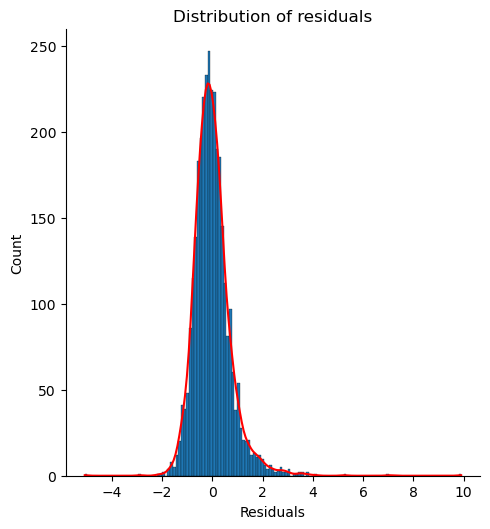

In [109]:
res=model.resid # residuals

sns.displot(data=res, kde=True,color='red',facecolor='tab:blue')
plt.xlabel('Residuals')
plt.title('Distribution of residuals')
plt.show()

#### Discussion 

We didn't add countries and languages to the regression because their p-values were very high, so those parameters didn't have a significant effect on success.

Prob (F-statistic) is  near 0, so the parameters are significant in explaining success. 

